In [2]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

import lightgbm as lgb

In [3]:
df_train = pd.read_csv(r"C:\Users\aarya\OneDrive\Desktop\skin_cancer\isic-2024-challenge\train-metadata.csv")
df_test = pd.read_csv(r"C:\Users\aarya\OneDrive\Desktop\skin_cancer\isic-2024-challenge\test-metadata.csv")

def feature_engineering(df):
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
    
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
] + new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

C:\Users\aarya\AppData\Local\Temp\ipykernel_33604\2895637516.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(r"C:\Users\aarya\OneDrive\Desktop\skin_cancer\isic-2024-challenge\train-metadata.csv")


In [4]:
gkf = GroupKFold(n_splits=5) # , shuffle=True, random_state=42

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

In [5]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

import random

__n_estimators         = random.choice([1400,1500,2000])                  # 800,900,1000,1100,1200,1300,
__learning_rate        = random.choice([0.003,0.002,0.001])               # 0.005,0.004,
__lambda_l1            = random.choice([0.14,0.21,0.27,0.37])
__lambda_l2            = random.choice([0.7,1.0,1.47,1.77,2.77])
__pos_bagging_fraction = random.choice([0.74, 0.75, 0.77, 0.777])
__neg_bagging_fraction = random.choice([0.04,0.05,0.07,0.077])
__feature_fraction     = random.choice([0.5,0.54,0.57,0.7,0.77,0.777])
__num_leaves           = random.choice([16, 20, 24, 30,33,37])            # 24,30,31,32,33,37
__min_data_in_leaf     = random.choice([16, 20, 24, 40,50,57])            # 40,45,50,55,57

lgb_params = {
    'objective': 'binary',
    "random_state": 42,
    "n_estimators":__n_estimators,
    'learning_rate':__learning_rate,
    'num_leaves':__num_leaves,
    'min_data_in_leaf':__min_data_in_leaf,
    'bagging_freq': 1,
    'pos_bagging_fraction':__pos_bagging_fraction,
    'neg_bagging_fraction':__neg_bagging_fraction,
    'feature_fraction':__feature_fraction,
    'lambda_l1':__lambda_l1,
    'lambda_l2':__lambda_l2,
    "verbosity": -1,
    # "extra_trees": True
}

print('\n',
      __n_estimators,
      __learning_rate,
      __lambda_l1,
      __lambda_l2,
      __pos_bagging_fraction,
      __neg_bagging_fraction,
      __feature_fraction,
      __num_leaves,
      __min_data_in_leaf,
'\n')

scores = []
models = []
for fold in range(5):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMRegressor(
        **lgb_params
    )
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict(_df_valid[train_cols])
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    scores.append(score)
    models.append(model)


 2000 0.002 0.37 1.0 0.77 0.04 0.77 24 57 

fold: 0 - Partial AUC Score: 0.16298
fold: 1 - Partial AUC Score: 0.15719
fold: 2 - Partial AUC Score: 0.15460
fold: 3 - Partial AUC Score: 0.16110
fold: 4 - Partial AUC Score: 0.15558


In [6]:
np.mean(scores)

0.1582910795976114

In [7]:
importances = np.mean([model.feature_importances_ for model in models], 0)
df_imp = pd.DataFrame({"feature": model.feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)

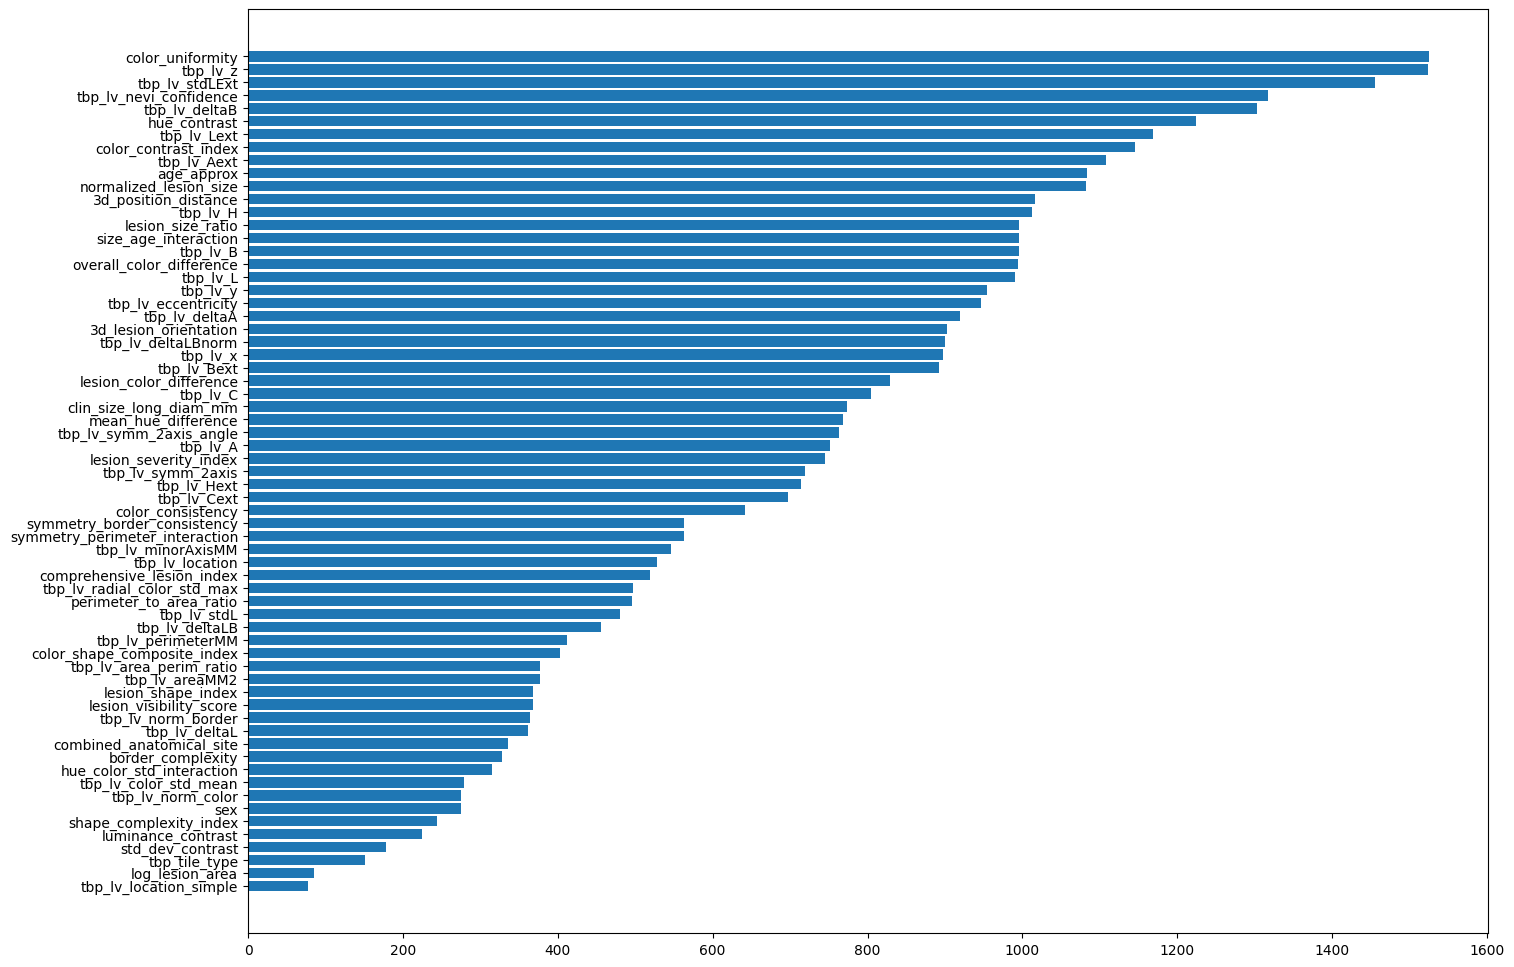

In [8]:
plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()

In [9]:
# How does the new feature(s) perform?
# I would go with the > 20 in the index.
df_imp[df_imp["feature"].isin(new_num_cols + new_cat_cols)].sort_values("importance", ascending=False)

,feature,importance
64,color_uniformity,1525.2
59,hue_contrast,1224.0
57,color_contrast_index,1145.2
54,normalized_lesion_size,1082.2
53,3d_position_distance,1016.6
51,lesion_size_ratio,995.6
50,size_age_interaction,995.2
48,overall_color_difference,994.8
43,3d_lesion_orientation,902.2
39,lesion_color_difference,828.4


In [10]:
X_cat = category_encoder.fit_transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat[:, c]

In [11]:
preds = np.mean([model.predict(df_test[train_cols]) for model in models], 0)

In [12]:
df_sub = pd.read_csv(r"C:\Users\aarya\OneDrive\Desktop\skin_cancer\isic-2024-challenge\sample_submission.csv")
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.001967
1,ISIC_0015729,0.001131
2,ISIC_0015740,0.004403


In [13]:
df_sub.to_csv("submission.csv", index=False)